P03 needs special treatment, because it has 44 rings instead of 43 (everybody else)

In [1]:
def flatten_arrays_to_lists(item):
    # If it's a NumPy array, flatten to 1D and convert to list
    if isinstance(item, np.ndarray):
        return item.flatten().tolist()
    # If it's a list, apply this function to each element
    elif isinstance(item, list):
        return [flatten_arrays_to_lists(x) for x in item]
    # If it's a dictionary, apply this function to each value
    elif isinstance(item, dict):
        return {k: flatten_arrays_to_lists(v) for k, v in item.items()}
    # Otherwise (int, float, str, etc.), leave as-is
    else:
        return item

In [2]:
import sys
import os

sys.path.append('../../../scripts')
sys.path.append('../../../models')

import copy
os.environ["CUDA_VISIBLE_DEVICES"]= '2' #, this way I would choose GPU 3 to do the work

from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"]= '0' #, this way I would choose GPU 3 to do the work

import torch
import numpy as np
import time
import h5py
import matplotlib.pyplot as plt
from scipy.ndimage import zoom # for compressing images / only for testing purposes to speed up NN training
from scipy.fft import fft2, fftshift
from scipy.io import loadmat
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torch.nn as nn
from scipy.io import loadmat
import random

from data_preparation import *
import plotly.graph_objects as gorings
import scipy.io as sio


AF = 8 # set acceleration factor

In the code below, I compute exactly how much percent of k-space is sampled at which k_z position

No handles with labels found to put in legend.


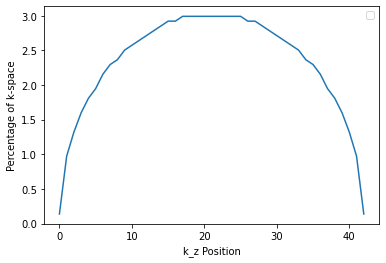

In [3]:
mat_data_8 = loadmat('../../fn_vb_DMI_CRT_P04/CombinedCSI_full_rank.mat')
csi_data = mat_data_8['csi']
Data = csi_data['Data'][0,0]

Par = csi_data['Par'][0,0]

Circles_Per_kz_Matrix = Par['AngIntsPerPartEnc'][0,0]

Circles_Per_kz = np.zeros(43)

for i in range(0,43):
    Circles_Per_kz[i] = np.sum(Circles_Per_kz_Matrix[i])

Percentage_Per_kz = 100*Circles_Per_kz / np.sum(Circles_Per_kz)

plt.plot(Percentage_Per_kz)

# Add labels and title
plt.xlabel("k_z Position")
plt.ylabel("Percentage of k-space")

# Add a legend
plt.legend()

# Show the plot
plt.show()

Compute how many central planes amount to ~20% of the data

In [4]:
#### Next I want to undersample in a complementary fashion. I generate a pool that has all indices that are not sampled 
#### except for ones that are always kept across time steps. 

def pool(kept_Indices, Number_Circles):
    all_indices = np.arange(Number_Circles)  # Generate array [0, 1, ..., Number_Circles-1]
    return np.delete(all_indices, kept_Indices)  # Remove indices in kept_Indices

**Reshaping**

The above code accomplishes that I have the complete k_space mask information in the format (k_z, T). If Mask[i,j] = 1, it means k_z position can be sampled at timestep T, otherwise not. However, in Matlab the data is saved is saved as csi.Data with the following format:

size(csi.Data) = 1 43; a list of 43 entries, one for each RING. Then size(csi.Data{i}) = 526 1 N 1 96 1 8; where N is the number of k_z partitions this ring appears in. Unfortunately, N is not directly the k_z index, but rather N = 1 corresponds to the smallest k_z index that has been measured etc. So what I want is this:

**Goal:**

I create a dictionary structure "ring_sampling" that mirrors the matlabl structure. So ring_sampling[i] is a list of list for ring i.
The outer list has 8 elements, for the 8 time steps, then each of these 8 inner lists has the indices that should be sampled.

**First step**

Create a matrix with the matlab indices for each Ring. I accomplish this by using the matrix Circles_Per_kz_Matrix which is 1 at index i,j if the ith kz position was measured by ring j, and 0 else. I multiply this matrix by a matrix of shape 43x43 point wise (same shape) which has 1 in the first row 2 in the second row etc. It is important to note that the k_z positions are counted beginning from 1 not 0.

In [5]:
Circles_Per_kz_Matrix[0,0]

# Create a column vector of row numbers (starting from 1)
n=43
row_numbers = np.arange(1, n + 1).reshape(n, 1)
matrix = np.tile(row_numbers, (1, n))
matrix_inverse = 1 / matrix

Sampled_Indices_Per_Ring = matrix * Circles_Per_kz_Matrix

print(Sampled_Indices_Per_Ring[:,42])

#Sampled_I_Per_Ring: This means e.g. Sampled_Indices_Per_Ring[:,0] gives all the k_z indizes (sstartng from 1 not 0 (!)) that have been sampled by Ring 0 etc.

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 18 19 20 21 22 23 24
 25 26  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


In here I save the minimum k_z positions that has been sampled per ring, again this starts at k_z = 0

In [6]:

Minimum_kz_position = np.zeros(43)

for i in range(0,43):
    Sampled_kz_ring_i = Sampled_Indices_Per_Ring[:,i]
    first_nonzero = next((x for x in Sampled_kz_ring_i if x != 0), None)
    Minimum_kz_position[i] = first_nonzero -1 #start at 0 not at 1

In [7]:
Minimum_kz_position

array([ 0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,  3.,  4.,  4.,  4.,
        5.,  5.,  6.,  6.,  6.,  7.,  7.,  8.,  9.,  9., 10., 11., 12.,
       13., 14., 15., 17.])

# ***Creating apropritate data structure***

Now I want to start to assemble which rings have actually been sampled. First I create a dictionary, containing 43 elements (rings) each containing a list of list (upper list 8 time steps, and then a list for what has been sampled at that time step by that ring). This is the format in which it is saved in matlab.

In [8]:
num_rings = 43
num_time_steps = 8

# Create a dictionary to hold the sampling info for each ring.
# Keys are ring numbers (here, 0-indexed; you can adjust to 1-indexed if you prefer).
# Each value is a list of length num_time_steps, where each element is a list of indices
# for that ring that are sampled at that time step.
ring_sampling = {}

for ring in range(num_rings):
    # For each ring, initialize an empty list for each time step.
    ring_sampling[ring] = [[] for _ in range(num_time_steps)]

ring_undersampling = copy.deepcopy(ring_sampling)

# Example: suppose for ring 0 at time step 0 we sampled indices [1, 3, 5]
#ring_sampling[0][0] = [1, 3, 5]

# And perhaps for ring 0 at time step 1 we sampled indices [2, 4]
#ring_sampling[0][1] = [2, 4]

#ring_sampling
 ##### LOAD IF FILE ALREADY AVAILABE"

# Define the file name
filename = f"csiUndersampled_AF{AF}.mat"

# Check if the file exists
if os.path.isfile(filename):
    helper = loadmat(filename)['csiUS'][0][0][0][0]
    
    for ring in range(43):
        if len(helper[ring]) > 0:
            for T in range(8):
                if len(helper[ring][0]) > T:
                    if len(helper[ring][0][T]) > 0:
                        ring_undersampling[ring][T] = helper[ring][0][T][0]
                    else:
                        print(f"Empty list at helper[{ring}][0][{T}]")
                else:
                    print(f"Index T={T} is out of bounds for helper[{ring}][0]")
        else:
            print(f"Empty list at helper[{ring}]")
    for ring in range(0,43): ## this loop converts everything back to the original python format, note that matlab saved this is a different format
        for T in range(0,8):
            ring_undersampling[ring][T] = ring_undersampling[ring][T] + (np.ones((len(ring_undersampling[ring][T])))*Minimum_kz_position[ring])
            
    ring_undersampling = flatten_arrays_to_lists(ring_undersampling)
else:
    print(f"File {filename} does not exist.")
    
filename = f"csiUndersampled_AF{AF}.mat"

File csiUndersampled_AF8.mat does not exist.


Next, I actually save something to that structure. I start with the fully sampled case.

In [9]:
for ring in range(0,43):
    for T in range(0,8):
        ring_sampling[ring][T] = np.array([x for x in Sampled_Indices_Per_Ring[:,ring] if x !=0]).reshape(-1)

In [10]:
def percentage_k_space(array, T):
    count = 0
    for i in range(0,43):
        count = count + len(array[i][T])
        
    return 100*(count/1437) #note that 1437 rings had been measured

percentage_k_space(ring_undersampling, 0)

0.0

In [11]:
import numpy as np

def sample_candidate(r_max, num_rings, kz_min, kz_max, r_min = 0):
    """
    Sample a candidate (ring, k_z) pair based on polar coordinates.
    
    Parameters:
      r_max    : maximum 3D distance from center (tunable based on k-space extent)
      num_rings: total number of rings (e.g., 43)
      kz_min   : minimum k_z index value (e.g., 0)
      kz_max   : maximum k_z index value (e.g., maximum index available per ring)
      
    Returns:
      candidate_ring: integer ring index in [0, num_rings-1]
      candidate_kz  : integer k_z index in [kz_min, kz_max]
    """
    # Randomly choose r and theta:
    r = np.random.uniform(r_min, r_max)
    theta = np.random.uniform(-np.pi/2, np.pi/2)
    
    # Compute candidate values:
    # Note: cos(theta) is always positive in [-pi/2, pi/2], so candidate_ring is nonnegative.
    candidate_ring_float = r * np.cos(theta)
    candidate_kz_float = r * np.sin(theta)/2
    
    # Round to nearest integer.
    candidate_ring = int(np.round(candidate_ring_float))
    candidate_kz = int(np.round(candidate_kz_float))
    
    # For the ring index, we assume the center corresponds to ring 0.
    # If your rings are defined from 0 to num_rings-1 (with 0 being the center),
    # you may leave candidate_ring as is. Otherwise, shift accordingly.
    # Here, we simply bound it to valid indices.
    candidate_ring = max(0, min(candidate_ring, num_rings - 1))
    
    # For k_z, assume that k_z = 0 is at the center.
    # Shift candidate_kz so that the center index is at (kz_min + kz_max)/2.
    kz_center = (kz_min + kz_max) / 2
    candidate_kz += int(np.round(kz_center))
    candidate_kz = max(kz_min, min(candidate_kz, kz_max))
    
    return candidate_ring, candidate_kz

# --- Example usage in an undersampling loop ---

# Parameters (tune these based on your k-space geometry)
num_rings = 43
r_max = 43               # maximum "3D distance" (adjust as appropriate)
kz_min = 1               # lowest k_z index
kz_max = 43             # highest k_z index for a given ring (example)

# Suppose you have structures 'ring_sampling' and 'ring_undersampling'
# For this example, assume ring_sampling[ring][T] is a list of available k_z indices
# for ring (and time point T), and ring_undersampling holds the ones already sampled.
# Also assume you have a function percentage_k_space(undersampling, T) that returns the
# percentage of k-space sampled for time T.

num_timepoints = 8
target_percentage = 100*(1/AF)  # e.g., 50%

for T in range(num_timepoints):
    # Continue sampling until your target percentage is reached.
    while percentage_k_space(ring_undersampling, T) < target_percentage:
        # Sample a candidate (ring, k_z) pair
        cand_ring, cand_kz = sample_candidate(r_max, num_rings, kz_min, kz_max)
        
        # Check if this candidate exists in your ring_sampling structure and
        # hasn't been selected yet.
        if cand_kz in ring_sampling[cand_ring][T]:
            if cand_kz not in ring_undersampling[cand_ring][T]:
                ring_undersampling[cand_ring][T].append(cand_kz)
                ring_undersampling[cand_ring][T].sort()

import numpy as np

# Ensure all entries in ring_undersampling are column vectors
for T in range(num_timepoints):
    for k in range(43):  # No need to explicitly write (0,43)
        if isinstance(ring_undersampling[k][T], list):  
            # Convert lists to NumPy arrays first
            ring_undersampling[k][T] = np.array(ring_undersampling[k][T])

        if ring_undersampling[k][T].ndim == 1:  # Ensure it's a 1D array before reshaping
            ring_undersampling[k][T] = ring_undersampling[k][T].reshape(-1) # Column vector

In [12]:
type(ring_undersampling)

dict

In [13]:
T = 2

percentage_k_space(ring_undersampling, T)

12.526096033402922

In [14]:
ring_undersampling_final_format = copy.deepcopy(ring_undersampling)

for ring in range(0,43):
    for T in range(0,8):
        ring_undersampling_final_format[ring][T] = ring_undersampling_final_format[ring][T] - (np.ones((len(ring_undersampling_final_format[ring][T])))*Minimum_kz_position[ring])

# ***Save to matlab file***

In [15]:
num_rings = 43

# Assuming ring_undersampling_final_format is a dictionary with keys 0, 1, ..., 42,
# where each ring_undersampling_final_format[ring] is a list (of 8 time steps) containing the sampled indices for that ring.
# Create an empty NumPy object array with shape (1, num_rings)
data_array = np.empty((1, num_rings), dtype=object)

# Fill the array with your data from each ring
for ring in range(num_rings):
    data_array[0, ring] = np.array(ring_undersampling_final_format[ring], dtype=object)

# Create a structure similar to your MATLAB structure, e.g., csi.Data
csiUndersampled = {'Data': data_array}

import os
import scipy.io as sio

filename = f'csiUndersampled_AF{AF}.mat'
if not os.path.exists(filename):
    sio.savemat(filename, {'csiUS': csiUndersampled})

# ***Visualize undersampling pattern***

I transform ring_undersampling into an array of shape 43x43x8 such that it contains 1 if ring i with kz index j has been measured at time t, 0 otherwise.


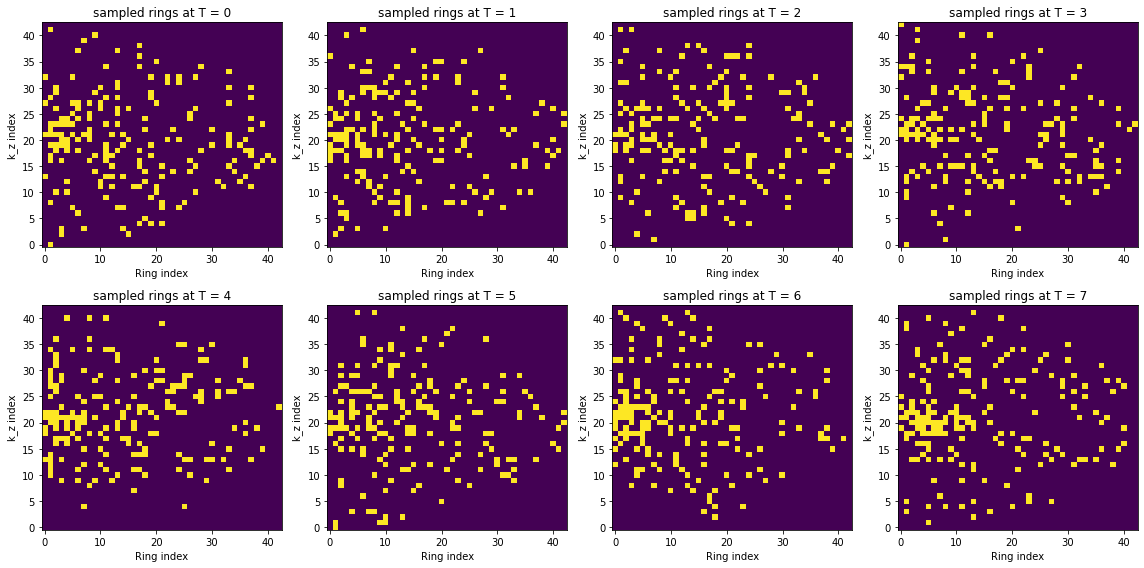

In [16]:
import numpy as np
import scipy.io as sio  # if you want to save the result for Matlab

# Create a 43x43x8 array filled with zeros
A = np.zeros((43, 43, 8), dtype=int)

# Loop through each ring (key) in the dictionary
for i in range(0, 43):          # Keys are 1-indexed: 1 to 43
    for t in range(8):          # There are 8 timesteps (0-indexed in Python)
        # For each sampled ring index j at time t, mark it in the array.
        for j in ring_undersampling[i][t]:
            A[i, int(j)-1, t] = 1  # Subtract 1 to convert to Python's 0-indexing

# Optionally, if you want to save the array to a .mat file for Matlab:

import matplotlib.pyplot as plt

# Create a figure with 2 rows and 4 columns
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
axes = axes.flatten()  # Flatten the array for easier iteration

# Loop over the 8 timesteps and plot the corresponding transposed 43x43 data
for t in range(8):
    ax = axes[t]
    # Transpose the 43x43 slice to swap the first two axes and set origin to lower left
    im = ax.imshow(A[:, :, t].T, origin='lower', cmap='viridis', interpolation='none', aspect='auto')
    
    # Set the title and labels
    ax.set_title(f"sampled rings at T = {t}")
    ax.set_xlabel("Ring index")
    ax.set_ylabel("k_z index")
    
    # Optionally, add a colorbar for reference
    #fig.colorbar(im, ax=ax, shrink=0.7)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()



**Reconstruction k-z Positions of Rings**

In [17]:
mat_data_4 = loadmat('../../fn_vb_DMI_CRT_P04/CombinedCSI_full_rank.mat')
csi_data = mat_data_4['csi']
par_data = csi_data['Par'][0,0]
Data_Size = par_data['DataSize'][0][0][0]
Data_Size

array([array([[526,   1,  43,   1,  96,   1,   8]], dtype=uint16),
       array([[526,   1,  43,   1,  96,   1,   8]], dtype=uint16),
       array([[526,   1,  41,   1,  96,   1,   8]], dtype=uint16),
       array([[526,   1,  41,   1,  96,   1,   8]], dtype=uint16),
       array([[526,   1,  41,   1,  96,   1,   8]], dtype=uint16),
       array([[526,   1,  41,   1,  96,   1,   8]], dtype=uint16),
       array([[526,   1,  41,   1,  96,   1,   8]], dtype=uint16),
       array([[526,   1,  41,   1,  96,   1,   8]], dtype=uint16),
       array([[526,   1,  41,   1,  96,   1,   8]], dtype=uint16),
       array([[526,   1,  41,   1,  96,   1,   8]], dtype=uint16),
       array([[526,   1,  41,   1,  96,   1,   8]], dtype=uint16),
       array([[526,   1,  41,   1,  96,   1,   8]], dtype=uint16),
       array([[526,   1,  41,   1,  96,   1,   8]], dtype=uint16),
       array([[526,   1,  41,   1,  96,   1,   8]], dtype=uint16),
       array([[526,   1,  39,   1,  96,   1,   8]], dtype=uint

In [18]:
# Number_Of_Rings = 0
# for i in range(0,43):
#     Number_Of_Rings = Number_Of_Rings +Data_Size[i][0][2]
# print('Total Number of Rings')
# print(Number_Of_Rings)

# print('Total Number of k-Space points')
# print(Number_Of_Rings*526)  Circles_Per_kz_Matrix

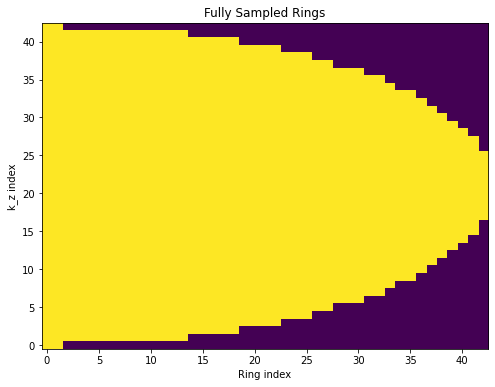

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Suppose matrix_2d is your 2D NumPy array (shape ~44x43)
# For demonstration, let's create a dummy matrix.
matrix_2d = np.random.randint(0, 2, (44, 43))

plt.figure(figsize=(8, 6))
# Display the matrix without transposing: 
# this will put the k_z index (second dimension) on the x-axis,
# and the ring index (first dimension) on the y-axis.
im = plt.imshow(Circles_Per_kz_Matrix, origin='lower', cmap='viridis', 
                interpolation='none', aspect='auto')

plt.title("Fully Sampled Rings")
plt.xlabel("Ring index")
plt.ylabel("k_z index")
plt.show()





In [20]:
172/(1437)

0.11969380654140571